In [1]:
import numpy as np
import networkx as nx
import plotly.graph_objects as go
import webbrowser
import os
import pandas as pd
import random
import string
import statistics
from src import create_fake_patients, whole_model_demographics_gradcam
from tensorflow import keras
import tensorflow as tf
from csv import writer
import seaborn as sns
import matplotlib.pyplot as plt
print("tensorflow version:", tf. __version__)
tf.config.list_physical_devices()


no_LSTM = False # True = without LSTM
exponential_scaling = True # True = with exponential
L1_ablation = True # True = with L1 reg
L2_ablation = True # True = with L2 reg
variable_gamma = True
graph_reg_incl = True

num_of_runs = 1
start_num = 1
    
weighted_loss = False # class weighted to deal with imbalance if True
no_timestamp = False # if no_timestamp = True then all values in 3-tensor = 1
activation_type = 'LeakyReLU' #'relu','gelu', 'LeakyReLU'
second_TGCNN_layer = True
demo = True
include_drugs = False
max_timesteps=100

run_name='hip_1999_to_one_year_advance_model'
years_in_advance = "5"

# strings for hyperparameter searching file
LSTM_str="LSTM excluded" if no_LSTM == True else "LSTM included"
exp_str = "exp excluded" if exponential_scaling == False else "exp included"
timestamp_str = "time elapsed = 1" if no_timestamp == True else "time elapsed"
weighted_loss_str = "weighted_loss" if weighted_loss ==True else "unweighted_loss"
L1_str = "L1 included" if L1_ablation == True else "L1 excluded"
L2_str = "L2 included" if L2_ablation == True else "L2 excluded"
second_layer_str = "Branched model" if second_TGCNN_layer == True else "Unbranched model"

if include_drugs:
    max_event_codes = 518
else:
    max_event_codes = 512
num_labels = 1 # number of outcomes -1 
hip_or_knee = 'hip'




model = whole_model_demographics_gradcam.TGCNN_Model(num_filters=16, num_nodes=max_event_codes, num_time_steps=max_timesteps, 
                            filter_size=4, variable_gamma=variable_gamma, 
                            exponential_scaling=exponential_scaling, dropout_rate=0.7, lstm_units=64,
                            fcl1_units=128, LSTM_ablation=no_LSTM, stride=1, activation_type=activation_type, 
                            no_timestamp=no_timestamp, second_TGCNN_layer=second_TGCNN_layer, num_labels=num_labels)
model.load_weights('hip_1999_to_one_year_advance_model1_CNN_layer')




tensorflow version: 2.10.1
normalised gamma [[0.02118205]]
normalised gamma [[0.00518636]]


In [2]:
cv_patients = create_fake_patients.create_fake_patient_df(num_patients=500, max_events=99, max_nodes=512)

# Generate an example patient of number n
n= 0

i_list = cv_patients.iloc[n]['indices'] # indices from patient cell
v_list = cv_patients.iloc[n]['values'] # values from patient cell

individual_sparse = tf.sparse.SparseTensor(i_list, v_list, (max_event_codes, max_event_codes, 100))

# Adding the sparse tensor to a list of all the tensors
ordered_indiv = tf.sparse.reorder(individual_sparse) # reorder required for tensor to work (no effect to outcome)
print(tf.sparse.expand_dims(ordered_indiv,axis=0))
input_4d = tf.sparse.expand_dims(ordered_indiv,axis=0)

outcome = cv_patients.iloc[n]['replace_type']

def classify_outcome(outcome):
    return 1 if outcome == 'hip' else 0

outcome_bin = classify_outcome(outcome)




# patient_dense_tensor = tf.sparse.to_dense(ordered_indiv)
#patient_dense_tensor

#demo_vals, demo_list, pat_num = utils.convert_demos_to_tensor(cv_patients, train_indices_list, demo)

demos = cv_patients[['gender', 'imd_quin', 'age_at_label_event']].iloc[n]
demos_z = demos.copy()
demos_z['age_zscore'] = 2
demos_z = demos_z.apply(pd.to_numeric)  
demo_vals = demos_z[['gender', 'imd_quin', 'age_zscore']].values 

demo = demos.apply(pd.to_numeric)
demo_list = demo[['gender', 'imd_quin', 'age_at_label_event']].values.tolist()
demo_tensor = tf.convert_to_tensor([demo_vals])

# print(demo_tensor)
# print(demo_list)

SparseTensor(indices=tf.Tensor(
[[  0   0  82  77]
 [  0   3  55  40]
 [  0   9 306  82]
 [  0  14  87  63]
 [  0  20 460  60]
 [  0  22 117  84]
 [  0  32 509  45]
 [  0  35 411  79]
 [  0  42 239  49]
 [  0  55 403  41]
 [  0  81 258  99]
 [  0  82  35  78]
 [  0  85 375  94]
 [  0  87 191  64]
 [  0  96 324  90]
 [  0 109 436  92]
 [  0 117 431  85]
 [  0 118   0  76]
 [  0 126 360  97]
 [  0 138   9  81]
 [  0 143 493  58]
 [  0 147 118  75]
 [  0 147 143  57]
 [  0 161 317  72]
 [  0 191 346  65]
 [  0 200 217  69]
 [  0 217 241  70]
 [  0 221 475  67]
 [  0 225  14  62]
 [  0 225 499  87]
 [  0 229 126  96]
 [  0 239 377  50]
 [  0 241 161  71]
 [  0 261 147  74]
 [  0 268 492  52]
 [  0 306  22  83]
 [  0 311  42  48]
 [  0 317 261  73]
 [  0 324 109  91]
 [  0 324 417  55]
 [  0 346 221  66]
 [  0 360  81  98]
 [  0 372  32  44]
 [  0 373 324  54]
 [  0 375 229  95]
 [  0 377 268  51]
 [  0 384 311  47]
 [  0 403 495  42]
 [  0 411 138  80]
 [  0 417 147  56]
 [  0 431 225  86]

In [3]:
logits = model(input_4d, demo_tensor, training=False)
print(logits)

grads = model.dy_du_branch1
print(grads.shape)

tf.Tensor([[0.10840181]], shape=(1, 1), dtype=float32)
(1, 16, 97)


In [4]:
grads

<tf.Tensor: shape=(1, 16, 97), dtype=float32, numpy=
array([[[-7.37343311e-11, -1.00957534e-10, -1.35005562e-10, ...,
          5.82115119e-03,  8.69200751e-03,  1.27575453e-02],
        [ 1.93824984e-10,  2.18235346e-10,  2.43759818e-10, ...,
         -6.10384997e-03, -8.19559302e-03, -1.05941324e-02],
        [ 2.11147405e-10,  2.57405292e-10,  3.13706200e-10, ...,
         -1.64712071e-02, -2.14281753e-02, -2.75330059e-02],
        ...,
        [ 1.36921613e-10,  1.77207277e-10,  2.28029692e-10, ...,
          1.98260555e-03,  1.23433641e-03,  1.33909867e-04],
        [ 2.21999391e-10,  2.78472218e-10,  3.47264106e-10, ...,
         -1.32848676e-02, -1.70248915e-02, -2.15413235e-02],
        [ 4.43260706e-12, -1.58432156e-11, -4.33277580e-11, ...,
          6.36288431e-04,  3.51413572e-03,  8.75335466e-03]]],
      dtype=float32)>

In [5]:
# for var in model.variables:
#     print(var.name)
#     print(var.numpy())

### Sub-graph drawing

#### Functions

In [6]:
def create_edges_df_gc(patient_graph:np.array):
    """Create a DataFrame of the edges of the patient graph, including the start and end nodes and the time 
    between visits. For Grad-CAM model.

    Args:
        patient_graph (np.array): 3D numpy array showing the patients health codes over time.

    Returns:
        DataFrame: with columns start_node, end_node, time_between.
    """

    # Get the indices of non-zero elements
    patient_graph = np.round(patient_graph.numpy(), 4)
    t_indices, i_indices, j_indices = np.nonzero(patient_graph)
    non_zero_values = []
    for t, i, j in zip(t_indices, i_indices, j_indices):
        non_zero_values.append(patient_graph[t, i, j])
    #print("Non-zero values", non_zero_values)
    if not non_zero_values:
        print("Error: Subgraph does not contain any values.")

    # Calculate start_node_v and end_node_v
    start_node_v = np.where(t_indices == 0, 0, t_indices)
    end_node_v = start_node_v + 1

    edges_df = pd.DataFrame({
        'start_node': [f'{i}_v{start_v}' for i, start_v in zip(i_indices, start_node_v)],
        'end_node': [f'{j}_v{end_v}' for j, end_v in zip(j_indices, end_node_v)],
        'time_between': non_zero_values
    })
    
    return edges_df

def extract_visit_number(s:str):
    """Extract the visit number from a string

    Args:
        s (str): string to split

    Returns:
        int: visit number
    """
    return int(s.split('_')[1][1:])

def create_position_df_gc(edges_df:np.array):
    """Create a DataFrame to find the number of nodes per visit. For Grad-CAM model.

    Args:
        edges_df (pd.DataFrame): DataFrame with columns start_node, end_node, time_between.

    Returns:
        pd.DataFrame: with columns showing node name (node), visit number (x), node number in visits (cumulative count),
        and maximum codes per visit.
    """
    pos_df = edges_df[['start_node', 'end_node']].stack().drop_duplicates().reset_index(drop=True)
    pos_df = pos_df.to_frame(name='node')
    pos_df['x'] = pos_df['node'].apply(extract_visit_number)
    pos_df['cumulative_count'] = pos_df.groupby('x').cumcount()
    pos_df['max_codes_per_visit'] = pos_df.groupby('x')['cumulative_count'].transform('max') + 1

    return pos_df

def generate_pos_sequence(x:int):
    """Generate a list of lists to get y coordinate positions for the nodes
     based on the number of events recorded per visit.

    Args:
        x (int): maximum number of nodes in any one visit

    Returns:
        List: List of lists of y coordinates index mapping to the max nodes for
               each visit.
    """
    sequence = []
    for i in range(x):
        if i % 2 == 0:  # Even index, include zero
            sequence.append(list(range(-i // 2, i // 2 + 1)))
        else:  # Odd index, exclude zero
            sublist = list(range(-(i // 2 + 1), i // 2 + 2))
            sublist.remove(0)
            sequence.append(sublist)
    return sequence


def get_pos_y_value_per_node(row, pos_list:list):
    """Get the y position for each node. Use max_codes_per_visit column to select the sublist 
    and the cumulative_count to get the position from the sublist.

    Args:
        row (pd.Series): row of the DataFrame

    Returns:
        int: y coordinate position 
    """
    cum_count = row['cumulative_count']
    max_codes = row['max_codes_per_visit']
    return pos_list[max_codes - 1][cum_count]

def map_y_coord_to_node(pos_df:pd.DataFrame, pos_list:list):
    """Map the y coordinates to the relevant node and correct row.

    Args:
        pos_df (pd.DataFrame): columns with node name and x coordinate.
        pos_list (list of lists): List of lists of y coordinates index mapping to the max nodes for
               each visit.

    Returns:
        pd.DataFrame: dataframe with x and y coordinates for node plotting.
    """
    pos_df['y'] = pos_df.apply(lambda row: get_pos_y_value_per_node(row, pos_list), axis=1)
    return pos_df

def create_pos_dict(pos_df:pd.DataFrame):
    """Make a dictionary with the node name as the key and the x and y coordinates 
    as a tuple value.

    Args:
        pos_df (pd.DataFrame): dataframe with columns for the node name, x coordinates,
        and y coordinates.

    Returns:
        dict: dictionary of node: (x,y)
    """
    # the visit number is x and the y value is the number of nodes with the same visit number
    pos = pos_df.set_index('node')[['x', 'y']].apply(tuple, axis=1).to_dict()
    return pos

def draw_gc_pat_graph(edges_df:pd.DataFrame, pos_dict:pd.DataFrame, graph_name:str, pat_outcome, stream_num:int=1):
    """Draw an individual patient's subgraph graph using NetworkX.

    Args:
        edges_df (pd.DataFrame): Dataframe with information about edges including: start and end nodes, and edge_label.
        pos_dict (dictionary): dictionary with x and y coordinates for each node:(x,y)
    """
    # Convert df to list of tuples for Networkx
    edges = []
    for _, row in edges_df.iterrows():
        edge = (row['start_node'], row['end_node'], {'edge_label': np.round(row['time_between']*30.4167).astype(int)}) # to get days instead of months * 30.4167
        edges.append(edge)

    G = nx.DiGraph()
    G.add_edges_from(edges)


    # Prepare edge colors, widths, and labels based on attributes
    edge_labels = {(u, v): G[u][v]['edge_label'] for u, v in G.edges()}

    # Draw the graph
    plt.figure(figsize=(edges_df['start_node'].nunique()+2, 8))
    nx.draw(G, pos_dict, with_labels=True, node_size=3000, node_color="lightblue", edge_color='grey', width=0.5, font_size=10, font_weight="bold", arrowsize=20)
    nx.draw_networkx_edge_labels(G, pos_dict, edge_labels=edge_labels, font_color='blue', font_size=10, font_weight='bold')
    if pat_outcome == 'hip':
        out_print = f'Patient will likely need a hip replacement in {years_in_advance} years time'
    else:
        out_print = f'It is unlikely this patient will need a hip replacement in {years_in_advance} years time'
    plt.title(f"Graph Visualisation of Patients Pathway and Connections Associated to Hip Replacement - Stream {stream_num}\n{out_print}")
    plt.savefig(f"{graph_name}.png", bbox_inches='tight')
    plt.show()
    plt.close()

def create_scrollable_html(image_path, html_path):
    # HTML template with a scrollable container
    html_content = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <style>
            .scrollable-container {{
                width: 100%;
                overflow-x: scroll;
                white-space: nowrap;
            }}
            .scrollable-container img {{
                display: block;
            }}
        </style>
        <title>Graph for Patient Subgraph</title>
    </head>
    <body>
        <div class="scrollable-container">
            <img src="{image_path}" alt="NetworkX Graph">
        </div>
    </body>
    </html>
    """

    # Write the HTML content to a file
    with open(html_path, 'w') as file:
        file.write(html_content)

### Run graph construction code - NetworkX

Branch 1

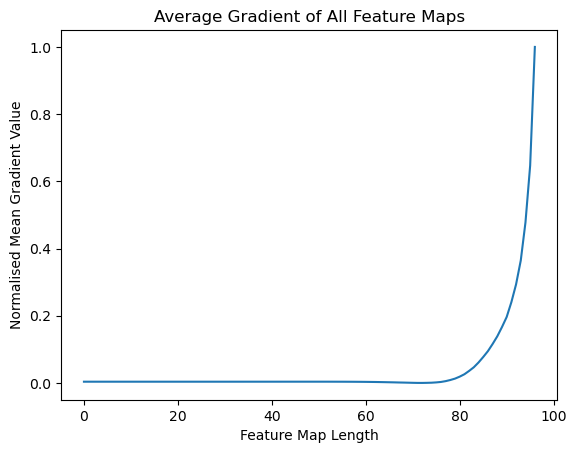

In [7]:
# overall measure average of all features

squeezed = tf.squeeze(grads)
squeezed = np.array(squeezed)
mean_features = np.mean(squeezed, axis=0)

grads_min = np.min(mean_features)
grads_max = np.max(mean_features)
norm_features = (mean_features - grads_min) / (grads_max - grads_min)
#norm_features = mean_features/np.sum(mean_features)

plt.plot(norm_features)
plt.title("Average Gradient of All Feature Maps")
plt.xlabel("Feature Map Length")
plt.ylabel("Normalised Mean Gradient Value")
plt.show()

96
100
(100, 512, 512)
  start_node end_node  time_between
0     258_v0    81_v1        0.5536
1      81_v1   360_v2        0.8785
2     360_v2   126_v3        0.5921
3     126_v3   229_v4        0.0136


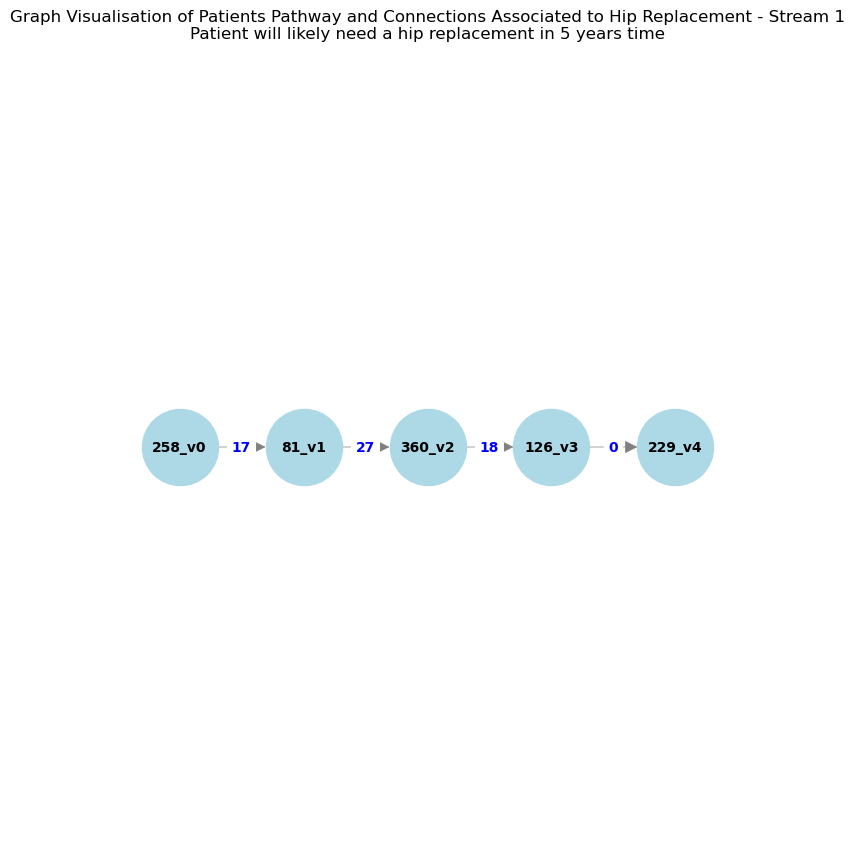

Graph image saved as pat_graph.png
HTML file saved as index.html


True

In [8]:
# Get the index of the with the largest number
max_val_idx = np.argmax(norm_features)
print(max_val_idx)

# Get the indexes for the respective filter in terms of the timesteps i.e. index + filter size -1 
filter_size = 4
timestep_max_idx = max_val_idx + filter_size
print(timestep_max_idx)


# Turn the sparse input graph into a dense graph
dense_tensor = tf.sparse.to_dense(ordered_indiv) # ordered_indiv is before the extra dimension is added for batching
dense_tensor

# Reshape to match graph visualisation code (and how I picture it in my noggin)
dense_tensor = tf.transpose(dense_tensor, perm=[2, 1, 0])
#print(dense_tensor.shape)

# Flip the graph so the most recent timesteps are at the front rather than the back
dense_tensor = np.flip(dense_tensor, axis=0)

print(dense_tensor.shape)

# Get the chunk of the input graph that corresponds to these timesteps
max_visits = 100
pat_subgraph = dense_tensor[max_visits-timestep_max_idx:max_visits-max_val_idx, :, :] # this need to be 100 minus these values as the tensor has been flipped
#print(pat_subgraph)



## Turn these input tensors into a NetworkX graph

# Get the edges for the graph
edges_df = create_edges_df_gc(pat_subgraph)
print(edges_df)

# Get the node positions for the graph
pos_df = create_position_df_gc(edges_df)
pos_list = generate_pos_sequence(pos_df['max_codes_per_visit'].max())
pos_df = map_y_coord_to_node(pos_df, pos_list)
pos_dict = create_pos_dict(pos_df)
# Draw the graph and display on HTML
graph_name = 'pat_graph'
image_path = graph_name+'.png'
html_path = 'index.html'
draw_gc_pat_graph(edges_df, pos_dict, graph_name=graph_name, pat_outcome=outcome)
create_scrollable_html(image_path, html_path)
print(f"Graph image saved as {image_path}")
print(f"HTML file saved as {html_path}")

# Open the HTML file
file_url = 'file://' + os.path.realpath(html_path)
webbrowser.open(file_url)

#### Branch 2

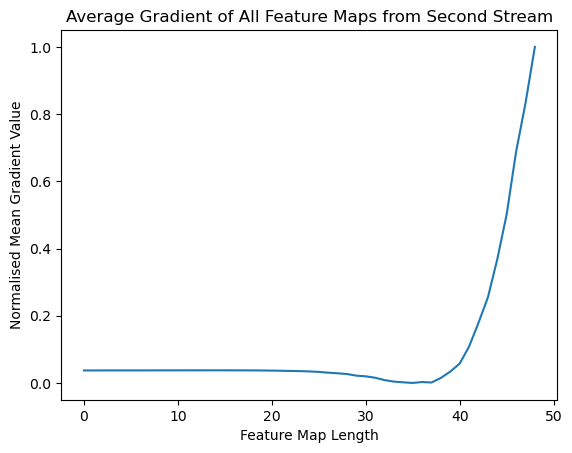

48
100
(100, 512, 512)
0 52
  start_node end_node  time_between
0     258_v0    81_v1        0.5536
1      81_v1   360_v2        0.8785
2     360_v2   126_v3        0.5921
3     126_v3   229_v4        0.0136


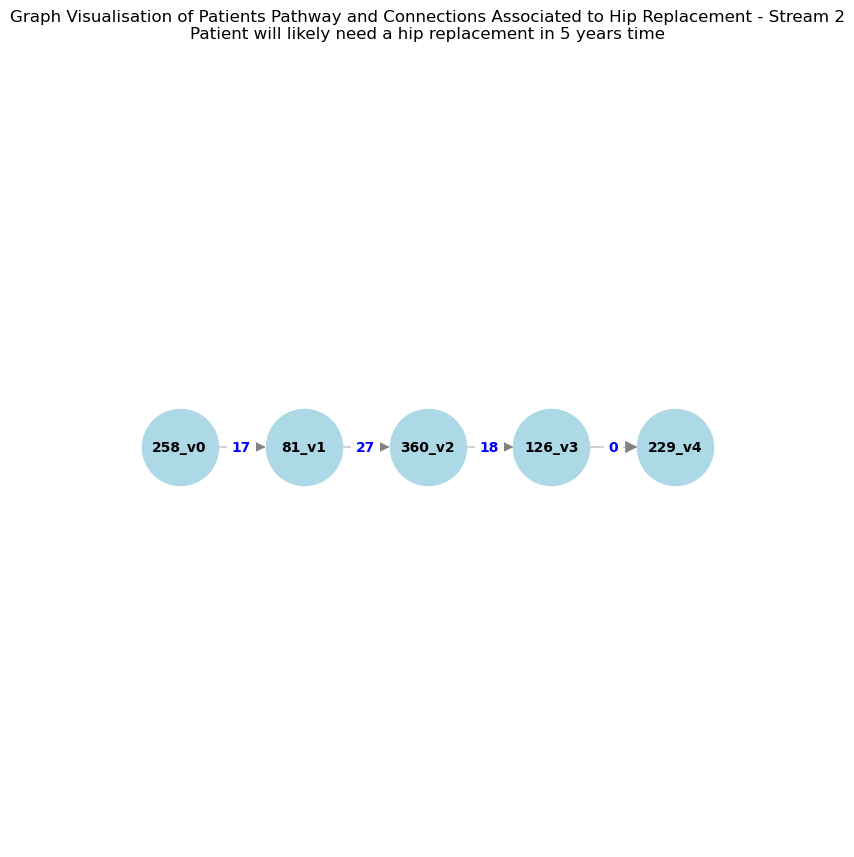

Graph image saved as pat_graph_stream2.png
HTML file saved as index_stream2.html


In [9]:
if second_TGCNN_layer:
    grads2 = model.dy_du_branch2
    squeezed2 = tf.squeeze(grads2)
    squeezed2 = np.array(squeezed2)
    mean_features2 = np.mean(squeezed2, axis=0)
    grads_min = np.min(mean_features2)
    grads_max = np.max(mean_features2)
    norm_features2 = (mean_features2 - grads_min) / (grads_max - grads_min)
    #norm_features2 = mean_features2/np.sum(mean_features2)

    plt.plot(norm_features2)
    plt.title("Average Gradient of All Feature Maps from Second Stream")
    plt.xlabel("Feature Map Length")
    plt.ylabel("Normalised Mean Gradient Value")
    plt.show()



    # Get the index of the with the largest number
    max_val_idx = np.argmax(norm_features2)
    print(max_val_idx)

    # Get the indexes for the respective filter in terms of the timesteps i.e. (index*stride) + filter size -1 
    # As the stride size in branch 2 is different I need to map the feature index back to the input graph differently
    # ((timesteps - filter_size)/stride)+1 = ((200 - 6)/2)+1 =  final feature map size
    stream_2_stride = 2
    timestep_max_idx = (max_val_idx*stream_2_stride) + filter_size
    print(timestep_max_idx)


    # Turn the sparse input graph into a dense graph
    dense_tensor = tf.sparse.to_dense(ordered_indiv) # ordered_indiv is before the extra dimension is added for batching

    # Reshape to match graph visualisation code (and how I picture it in my noggin)
    dense_tensor = tf.transpose(dense_tensor, perm=[2, 1, 0])
    #print(dense_tensor.shape)

    # Flip the graph so the most recent timesteps are at the front rather than the back
    dense_tensor = np.flip(dense_tensor, axis=0)

    print(dense_tensor.shape)

    # Get the chunk of the input graph that corresponds to these timesteps
    max_visits = 100

    print(max_visits-timestep_max_idx, max_visits-max_val_idx)
    pat_subgraph = dense_tensor[max_visits-timestep_max_idx:max_visits-timestep_max_idx+filter_size, :, :]
    #print(pat_subgraph)


    ## Turn these input tensors into a NetworkX graph

    # Get the edges for the graph
    edges_df = create_edges_df_gc(pat_subgraph)
    print(edges_df)

    # Get the node positions for the graph
    pos_df = create_position_df_gc(edges_df)
    pos_list = generate_pos_sequence(pos_df['max_codes_per_visit'].max())
    pos_df = map_y_coord_to_node(pos_df, pos_list)
    pos_dict = create_pos_dict(pos_df)


    # Draw the graph and display on HTML
    graph_name = 'pat_graph_stream2'
    image_path = graph_name+'.png'
    html_path = 'index_stream2.html'
    draw_gc_pat_graph(edges_df, pos_dict, graph_name=graph_name, pat_outcome= outcome, stream_num=2)
    create_scrollable_html(image_path, html_path)
    print(f"Graph image saved as {image_path}")
    print(f"HTML file saved as {html_path}")
    
    # Open the HTML file
    file_url = 'file://' + os.path.realpath(html_path)
    webbrowser.open(file_url)

#### Look at each feature maps gradients individually

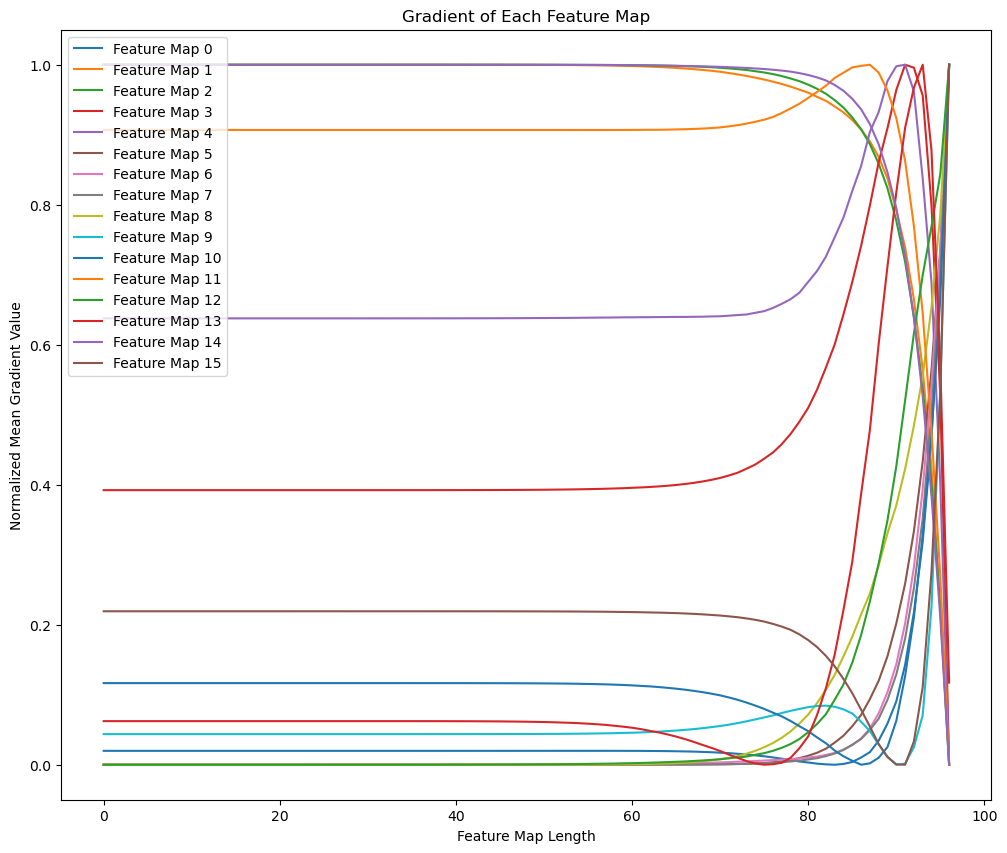

In [10]:
plt.figure(figsize=(12, 10))
for map in range(grads.shape[1]):
    np_grads = np.array(grads[0, map, :])
    grads_min = np.min(np_grads)
    grads_max = np.max(np_grads)
    norm_grads = (np_grads - grads_min) / (grads_max - grads_min)

    plt.plot(norm_grads, label=f'Feature Map {map}')

plt.title("Gradient of Each Feature Map")
plt.xlabel("Feature Map Length")
plt.ylabel("Normalized Mean Gradient Value")
plt.legend(loc='upper left')  # This will automatically use the labels specified in plt.plot
plt.show()

### Plotly/NetworkX Grad-CAM graph

In [11]:
# Get the entire patient's history in a DataFrame instead of just the subgraph
edges_df = create_edges_df_gc(dense_tensor)

# Get the node positions for the graph
pos_df = create_position_df_gc(edges_df)
pos_list = generate_pos_sequence(pos_df['max_codes_per_visit'].max())
pos_df = map_y_coord_to_node(pos_df, pos_list)

In [12]:
# Get the average gradient value per timestep

def generate_filt_sequences(stride, filter_size, feature_map_size):
    sequences = []

    for t in range(feature_map_size):
        start_idx = t * stride + 1
        
        end_idx = start_idx + filter_size
        
        # Generate the list of indices for this timestep
        indices = list(range(start_idx, end_idx))
        
        # Append to sequences
        sequences.append(indices)
    
    return sequences

stride = 1
filter_size = 4

sequences = generate_filt_sequences(stride, filter_size, norm_features.shape[0]+1)
sequences

def find_indices_of_value(list_of_lists, value):
    # Use a list comprehension to find the indices of lists containing the value
    return [index for index, sublist in enumerate(list_of_lists) if value in sublist]


f_map_indices = []
for f in range(1, max_timesteps+1): # this needs to be 
    f_map_indices.append(find_indices_of_value(sequences, f))

len(range(1, norm_features.shape[0]+1))
timestep_ave_grad_df = pd.DataFrame({
                        'timestep': list(range(max_timesteps, 0, -1)), 
                        'f_map_indices' : f_map_indices 
                                     })
timestep_ave_grad_df

index_values = timestep_ave_grad_df['f_map_indices'].values

timestep_ave_grads_lst = []
for index, row in timestep_ave_grad_df.iterrows():
    grad_lst_per_timestep = []
    for i in range(0, len(row['f_map_indices'])):
        grad_lst_per_timestep.append(norm_features[i])
    # get the mean of the norm_features for each time_step
    timestep_ave_grads_lst.append(statistics.mean(grad_lst_per_timestep))

timestep_ave_grad_df['timestep_ave_grad'] = timestep_ave_grads_lst


# this is the gradient per timestep but not all of the patients will have all the timesteps covered so need to take the top x rows (most recent)
# flip these to have the same order as node occurence


timestep_ave_grad_df['x'] = timestep_ave_grad_df['timestep']

# nodes in position x = 0 is the same as nodes in position x = 1 so can just duplicate the value here
new_row_dup = {'timestep': 0, 'f_map_indices': timestep_ave_grad_df['f_map_indices'].iloc[-1], 'timestep_ave_grad': timestep_ave_grad_df['timestep_ave_grad'].iloc[-1], 'x':0}


timestep_ave_grad_df.loc[len(timestep_ave_grad_df)] = new_row_dup
timestep_ave_grad_df


,timestep,f_map_indices,timestep_ave_grad,x
0,100,[0],0.003642,100
1,99,"[0, 1]",0.003642,99
2,98,"[0, 1, 2]",0.003642,98
3,97,"[0, 1, 2, 3]",0.003642,97
4,96,"[1, 2, 3, 4]",0.003642,96
...,...,...,...,...
96,4,"[93, 94, 95, 96]",0.003642,4
97,3,"[94, 95, 96, 97]",0.003642,3
98,2,"[95, 96, 97]",0.003642,2
99,1,"[96, 97]",0.003642,1


In [13]:
# fake mapping dataframe for the ReadCodes and the corresponding descriptions
read_code_map_df = pd.read_csv('fake_read_code_descriptions.csv')

In [14]:
# Extract the numeric part from the 'node' column in pos_df
pos_df['node_num'] = pos_df['node'].str.extract('(\d+)').astype(int)

merged_pos_df = pos_df.merge(read_code_map_df, on='node_num', how='left')

# merge the x cols in timestep_ave_grad_df with merged_pos_df x col to assign grad strength to nodes
merged_pos_df = merged_pos_df.merge(timestep_ave_grad_df, on='x', how='left')

# normalise (min-max) the timestep_ave_grad column (needed as not all of the timesteps are used and should give better y axis values)
merged_pos_df['norm_timestep_ave_grad'] = (merged_pos_df['timestep_ave_grad'] - merged_pos_df['timestep_ave_grad'].min()) / (merged_pos_df['timestep_ave_grad'].max() - merged_pos_df['timestep_ave_grad'].min())

merged_pos_df.head()

,node,x,cumulative_count,max_codes_per_visit,y,node_num,ReadCode,ReadCode_descript,timestep,f_map_indices,timestep_ave_grad,norm_timestep_ave_grad
0,258_v0,0,0,1,0,258,YggfK,258 ReadCode descript here,0,"[96, 97]",0.003642,0.000000
1,81_v1,1,0,1,0,81,hbSQs,81 ReadCode descript here,1,"[96, 97]",0.003642,0.000000
2,360_v2,2,0,1,0,360,LeHoD,360 ReadCode descript here,2,"[95, 96, 97]",0.003642,0.333333
3,126_v3,3,0,1,0,126,dNzzZ,126 ReadCode descript here,3,"[94, 95, 96, 97]",0.003642,1.000000
4,229_v4,4,0,1,0,229,GdcbS,229 ReadCode descript here,4,"[93, 94, 95, 96]",0.003642,1.000000


In [15]:
# edges_df merge to pos_df to get x0 and x1 and y0 and y1 for edges

# merge edges_df with pos_df on start_node to get x0 and y0
edge_pos_df = edges_df.merge(pos_df, how='left', left_on='start_node', right_on='node')
edge_pos_df = edge_pos_df.rename(columns={'x': 'x0', 'y': 'y0'}).drop(columns=['node', 'cumulative_count', 'max_codes_per_visit'])

# merge the result with pos_df again on end_node to get x1 and y1
edge_pos_df = edge_pos_df.merge(pos_df, how='left', left_on='end_node', right_on='node')
edge_pos_df = edge_pos_df.rename(columns={'x': 'x1', 'y': 'y1'}).drop(columns=['node', 'cumulative_count', 'max_codes_per_visit'])
edge_pos_df.head()

,start_node,end_node,time_between,x0,y0,node_num_x,x1,y1,node_num_y
0,258_v0,81_v1,0.5536,0,0,258,1,0,81
1,81_v1,360_v2,0.8785,1,0,81,2,0,360
2,360_v2,126_v3,0.5921,2,0,360,3,0,126
3,126_v3,229_v4,0.0136,3,0,126,4,0,229
4,229_v4,375_v5,0.1156,4,0,229,5,0,375


In [16]:
# Generate edge_x and edge_y
edge_x = []
edge_y = []

for _, row in edge_pos_df.iterrows():
    edge_x.extend([row['x0'], row['x1'], None])
    edge_y.extend([row['y0'], row['y1'], None])

# Create edge_trace
edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',  # Disable hover info for lines
    mode='lines'
)

# Generate node_x and node_y lists
node_x = pos_df['x'].tolist()
node_y = pos_df['y'].tolist()
node_labels = merged_pos_df['ReadCode'].tolist()
node_hover_text = merged_pos_df['ReadCode_descript'].tolist()


# Map the text colour based on the colour of the node so that it can be read
def text_color_mapping(numbers):
    return ['black' if num < 0.5 else 'white' for num in numbers]

text_colors = text_color_mapping(merged_pos_df['norm_timestep_ave_grad'].to_list())

# Create node_trace with static labels and hover text
node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    text=node_labels,  # Static labels for nodes
    textposition='middle center', 
    textfont=dict(
        size=10,
        color=text_colors  # Set color for edge text
    ),
    hoverinfo='text',  # Configure hover info
    marker=dict(
        showscale=True,
        colorscale='Viridis',
        reversescale=True,
        color='black',
        size=45,
        colorbar=dict(
            thickness=15,
            title='Influence Visit Had on Prediction (Gradient)',
            xanchor='left',
            titleside='right'
        ),
        line_width=2
    ),
    # Add hover text as a separate trace if needed
    hovertext=node_hover_text
)

node_trace.marker.color = merged_pos_df['norm_timestep_ave_grad'].to_list() # colour the markers based on the number of node connections


# Calculate midpoints for annotations (optional)
annotations = []
for _, row in edge_pos_df.iterrows():
    mid_x = (row['x0'] + row['x1']) / 2
    mid_y = (row['y0'] + row['y1']) / 2
    annotations.append(
        dict(
            x=mid_x,
            y=mid_y,
            text=f"{int(round(row['time_between']*30.4167,0))} days",
            showarrow=False,
            font=dict(size=10),
            align="center"
        )
    )

if outcome == 'hip':
    out_print = f'Patient will likely need a hip replacement in {years_in_advance} years time.'
else:
    out_print = f'It is unlikely this patient will need a hip replacement in {years_in_advance} years time.'
stream_num = '1'

proba_of_replace = 1/ (1+np.exp(logits)) # use sigmoid to convert logits to probs
annotations.append(dict(
                    text=f"The probability of this patient needing a replacement is {round(proba_of_replace.item()*100,2)}%. {out_print}",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ))

# Create the figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title=f'Graph Visualisation of Patients Pathway and Connections Associated to Hip Replacement - Stream {stream_num}.',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=10, r=5, t=50),
                    annotations=annotations,
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

if ((proba_of_replace.item() > 0.5) and (outcome != 'hip')) or ((proba_of_replace.item()) < 0.5) and (outcome == 'hip'):
    print("Model predicted incorrectly")

fig.show()

Model predicted incorrectly
